In [1]:
%matplotlib inline
import sys, os, time, math, csv
import itertools
import collections

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy.stats
import sklearn.metrics

### Load "Hammer" estimated number of housing units per block group

In [2]:
county_fip_list = []
block_group_fip_list = []
block_group_estimates = []

f = open("data/processed/hammer_historical_housing_units.csv", "r")
f.readline()
for line in f:
    line = line.strip()
    if line != "":
        parts = line.split(",")
        county_fips = parts[0]
        block_group_fips = parts[1]
        values = list(map(float,parts[2:]))
        
        county_fip_list.append(county_fips)
        block_group_fip_list.append(block_group_fips)
        block_group_estimates.append(values)
f.close()

block_group_estimates = np.array(block_group_estimates)
n = block_group_estimates.shape[0]
m = block_group_estimates.shape[1]

### Create a regression model for each block group

In [3]:
regression_results = np.zeros((n, 6), dtype=float)

xs_lin = np.arange(m)
xs_log = np.log(xs_lin+1.0)

for i in range(n):
    if i%10000 == 0:
        print("%d/%d" % (i, n))

    ys = block_group_estimates[i,:]
    
    if ys[0] <=  ys[-1]:
        slope, intercept, r_value, p_value, stderr = scipy.stats.linregress(xs_lin, ys)
        lin_flag = 1
    else:
        ys_log = np.log(ys+1.0)
        slope, intercept, r_value, p_value, stderr = scipy.stats.linregress(xs_log, ys_log)
        lin_flag = 0
        
    regression_results[i,:] = [slope, intercept, r_value, p_value, stderr, lin_flag]

0/216330
10000/216330
20000/216330
30000/216330
40000/216330
50000/216330
60000/216330
70000/216330
80000/216330
90000/216330
100000/216330
110000/216330
120000/216330
130000/216330
140000/216330
150000/216330
160000/216330
170000/216330
180000/216330
190000/216330
200000/216330
210000/216330


### Validate regression models over the training years

In [4]:
years = [
    1940,
    1950,
    1960,
    1970,
    1980,
    1990,
    2000,
    2010
]

In [5]:
predicted_ys = []
for i in range(n):
    if regression_results[i,-1] == 1:
        ys = xs_lin * regression_results[i,0] + regression_results[i, 1]
        predicted_ys.append(ys)
    else:
        ys = np.exp(xs_log * regression_results[i,0] + regression_results[i, 1])
        predicted_ys.append(ys)
predicted_ys = np.array(predicted_ys)

In [6]:
for i in range(m):
    print(i, sklearn.metrics.r2_score(block_group_estimates[:,i], predicted_ys[:,i]))

0 0.7541934544282467
1 0.9178039055168994
2 0.866417107899347
3 0.7551336016952886
4 0.7594661954710185
5 0.8347489519022202
6 0.9200998023484516
7 0.8139597421845556


We expect the above result to be this:
```
0 0.7541934544282467
1 0.9178039055168994
2 0.866417107899347
3 0.7551336016952886
4 0.7594661954710185
5 0.8347489519022202
6 0.9200998023484516
7 0.8139597421845556
```

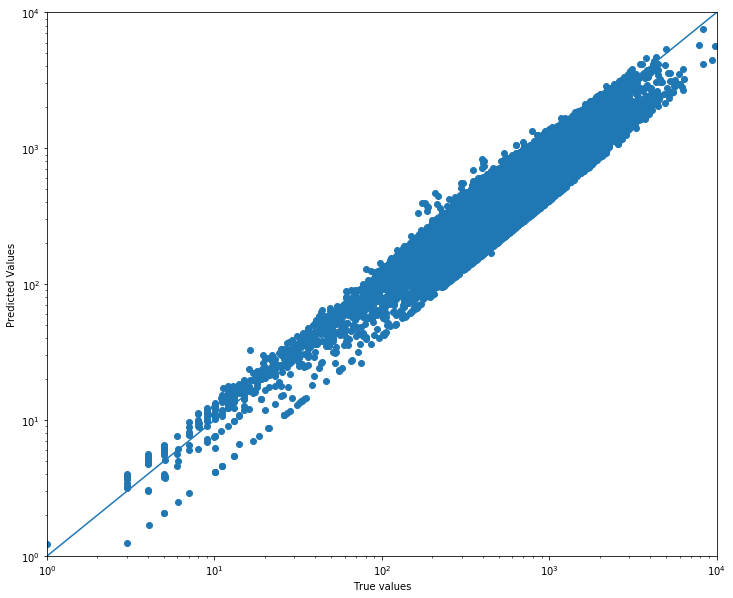

In [8]:
plt.figure(figsize=(12,10))

limits = [1e0, 1e4]

plt.plot(limits, limits)
plt.scatter(block_group_estimates[:,-1], predicted_ys[:,-1])

plt.xlim(limits)
plt.ylim(limits)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("True values")
plt.ylabel("Predicted Values")

plt.show()
plt.close()

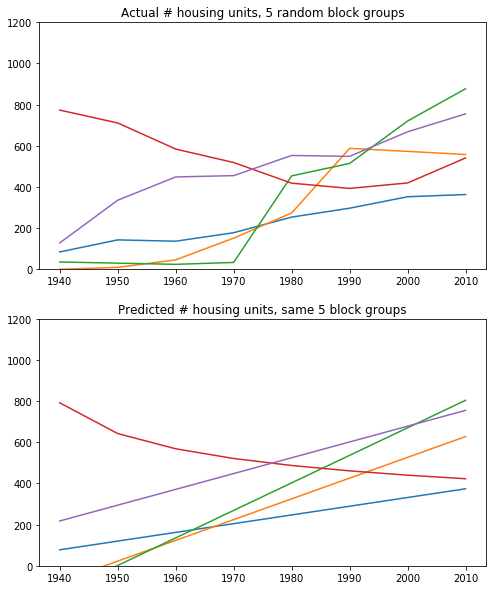

In [9]:
visualize_indices = np.random.randint(0,n,(5,))

fig, axs = plt.subplots(2,1,figsize=(8,10))
axs = axs.flatten()

# Actual
axs[0].plot(years, block_group_estimates[visualize_indices,:].T)
axs[0].set_ylim([0,1200])
axs[0].set_title("Actual # housing units, 5 random block groups")

axs[1].plot(years, predicted_ys[visualize_indices].T)
axs[1].set_ylim([0,1200])
axs[1].set_title("Predicted # housing units, same 5 block groups")

plt.show()
plt.close()

### Apply regression models to estimate number of housing units for each year in the range from 2010-2100

In [10]:
predicted_housing_units = []

xs_lin = np.arange(7, 16+0.01, 0.1)
xs_log = np.log(xs_lin+1)
predicted_years = np.round((1940.0 + (10.0*xs_lin))).astype(int)
print(predicted_years[1:] - predicted_years[:-1])
print(predicted_years)

for i in range(n):
    slope = regression_results[i,0]
    intercept = regression_results[i, 1]
    is_linear = regression_results[i,-1] == 1
    
    if is_linear:
        ys = (xs_lin * slope + intercept) + (block_group_estimates[i,-1] - (xs_lin[0]*slope + intercept))
    else:
        ys = np.exp(xs_log * slope + intercept) + (block_group_estimates[i,-1] - np.exp(xs_log[0] * slope + intercept))
        
    predicted_housing_units.append(ys)

predicted_housing_units = np.array(predicted_housing_units)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037
 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051
 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065
 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079
 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093
 2094 2095 2096 2097 2098 2099 2100]


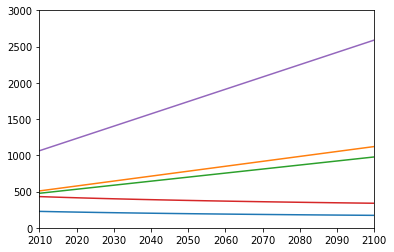

In [11]:
# Predicted
number_to_visualize = 5
plt.figure()
plt.plot(predicted_years, predicted_housing_units[:number_to_visualize].T)

plt.xlim([2010,2100])
plt.ylim([0,3000])
plt.show()
plt.close()

### Write houshold estimates

In [15]:
f = open("data/processed/regression_estimated_housing_units.csv", "w")
f.write("Geo_COUNTY_FIPS,Geo_BG_FIPS,%s\n" % (",".join(map(str, predicted_years))))
for i in range(n):
    f.write("%s,%s,%s\n" % (
        county_fip_list[i],
        block_group_fip_list[i],
        ",".join(map(str, predicted_housing_units[i,:]))
    ))
f.close()